## Importing libraries and setting up environment

In [54]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# import specific components from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay

# enhanced stats functions
from scipy import stats

# for ease of data profiling
from pandas_profiling import ProfileReport

In [2]:
# print environment setup details
print(f"pandas version  : {pd.__version__}")  # 1.4.3
print(f"numpy version   : {np.__version__}")  # 1.23.1
print(f"seaborn version : {sns.__version__}") # 0.11.2

pandas version  : 1.4.3
numpy version   : 1.23.1
seaborn version : 0.11.2


In [3]:
# set the number of columns for display so we can see all of them
pd.set_option('display.max_columns', 500)

Here, we also set the seed for numpy's random number generator such that our results are fully reproducible. This is because the other libraries (e.g. scikit-learn) use this random number generator, so if we set the seed we will always generate the same random numbers in the same sequence.

Thus, whenever we run the notebook from top-to-bottom, we will end up with the *exact* same results! 

## reading the dataset

In [4]:
SEED = 123
np.random.seed(SEED)

In [5]:
# read in data
df = pd.read_csv('bank-additional-full.csv',delimiter=";")

In [6]:
# make sure data was read in properly and matches above table
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
# optional: use pandas-profiling to do quick first pass at EDA
profile = ProfileReport(df, title="Bank Marketing Dataset Profiling Report")
# create html file to view report
profile.to_file("bank_marketing_dataset_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# conduct any other EDA that you need to in order to get a good feel for the data
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [9]:
# calculate percentage of users where y == "yes"
df['y'].value_counts()['yes']
len(df.index)

41188

This is interesting, it seems the vast majority of users did not subscribe to a deposit. This is very important to note - we have what's called an "imbalanced classification" problem - i.e. we do not have balance in the classes that we are classifying. This affects how we will handle our modelling later, and we'll revisit this. For now, just keep this fact in mind.

In [10]:
# determine number of duplicate rows
duplicate=df[df.duplicated()]
len(duplicate)

12

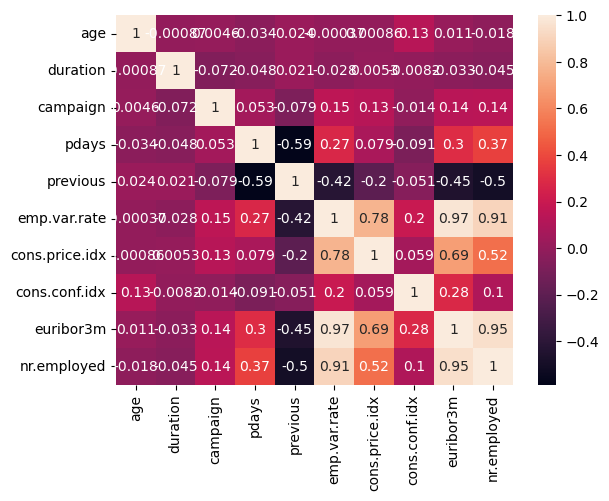

In [11]:
# plot correlation heatmap to get a sense of what variables are correlated
dataplot=sns.heatmap(df.corr(),annot=True)

plt.show()

In [12]:
# drop duplicates in-place, and reset the index so no index values are skipped
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [13]:
df.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41171,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41172,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41173,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41174,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41175,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,239,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


In [14]:
# test to make sure nothing left is duplicated
assert df.duplicated().any() == False, "Some duplicates remain."

In [15]:
# drop variables from df
df.drop(['duration','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'],axis=1,inplace=True)

In [16]:
print(f"variables after dropping: {len(df.columns)}")

variables after dropping: 15


## Now, get dummy variables for all our categorical variables using `pd.get_dummies()`, ensuring to use the `drop_first=True` argument to mitigate possible multicollinearity issues.

In [17]:
# get dummies for all categorical variables
df=pd.get_dummies(df,drop_first=True)


In [18]:
print(f"variables after getting dummies: {len(df.columns)}")

variables after getting dummies: 48


In [19]:
# get list of all variable combinations from highest correlation to lowest
all_vars = []
var_names = df.columns
for row_num, row in enumerate(df.corr().itertuples(index=False)):
    for col_num, value in enumerate(row):
        if col_num == row_num: continue
        all_vars.append((var_names[col_num], var_names[row_num], value))
sorted(all_vars, key=lambda x: abs(x[2]), reverse=True)

[('loan_unknown', 'housing_unknown', 1.0),
 ('housing_unknown', 'loan_unknown', 1.0),
 ('poutcome_success', 'pdays', -0.9506995106917704),
 ('pdays', 'poutcome_success', -0.9506995106917704),
 ('poutcome_nonexistent', 'previous', -0.8787710256314933),
 ('previous', 'poutcome_nonexistent', -0.8787710256314933),
 ('marital_single', 'marital_married', -0.7737655979161692),
 ('marital_married', 'marital_single', -0.7737655979161692),
 ('previous', 'pdays', -0.5875076785088075),
 ('pdays', 'previous', -0.5875076785088075),
 ('poutcome_success', 'previous', 0.5240380113196121),
 ('previous', 'poutcome_success', 0.5240380113196121),
 ('poutcome_nonexistent', 'pdays', 0.4913441513874407),
 ('pdays', 'poutcome_nonexistent', 0.4913441513874407),
 ('education_professional.course', 'job_technician', 0.48443241028470047),
 ('job_technician', 'education_professional.course', 0.48443241028470047),
 ('poutcome_success', 'poutcome_nonexistent', -0.46691950086405054),
 ('poutcome_nonexistent', 'poutcome

Regardless, there are still a number of variables which are still strongly correlated to each other. In fact, there are some which are *exactly* identical to one another! So we'll remove a few more variables:
* loan_unknown
* poutcome_success
* poutcome_nonexistent

In theory, a better approach would likely be to remove variables depending on whether our model improves or not when they are removed. For the sake of simplicity, we're doing this analysis just from data to model, but normally your model's performance would feedback on the choices of your data handling/variable selection/feature engineering, and you'd adjust accordingly.

In [20]:
# drop these 3 other variables from df
df.drop(['loan_unknown','poutcome_success','poutcome_nonexistent'],axis=1,inplace=True)

In [21]:
# rename "y_yes" column to "deposit"
df.rename(columns={'y_yes':'deposit'},inplace=True)

In [22]:
list(df.columns)

['age',
 'campaign',
 'pdays',
 'previous',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_unknown',
 'default_yes',
 'housing_unknown',
 'housing_yes',
 'loan_yes',
 'contact_telephone',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_of_week_wed',
 'deposit']

In [23]:
# split up our variables
X = df[['age',
 'campaign',
 'pdays',
 'previous',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_unknown',
 'default_yes',
 'housing_unknown',
 'housing_yes',
 'loan_yes',
 'contact_telephone',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_of_week_wed',
 ]]
y = df['deposit']

In [24]:
# the resulting shapes of X and y 
print(X.shape)
print(y.shape)

(41176, 44)
(41176,)


## performing the splitting of data

In [25]:
# do the train test split
X_train, X_test, y_train, y_test =  train_test_split( X, y, test_size=0.3, random_state=123)

In [26]:
print("expected : 29491, 26771, 22437, 6760, 28406")
print("actual   : " + ", ".join([str(x) for x in X_train.head().index]))

expected : 29491, 26771, 22437, 6760, 28406
actual   : 29491, 26771, 22437, 6760, 28406


In [27]:
# fit scaler
scaler = StandardScaler()
scaler.fit(X_train,y_train)

StandardScaler()

In [28]:
# transform X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
# visualize results
X_train[0]

array([-0.86772769,  1.25793763,  0.19318477, -0.34824353, -0.53746629,
       -0.18938592, -0.16367411, -0.27511045, -0.20651731, -0.18997485,
       -0.32646068, -0.14654834,  2.25605741, -0.15497345, -0.08949119,
       -1.24030365,  1.60004786, -0.04332459, -0.24483034, -0.4127161 ,
       -0.54983855, -0.02204448,  2.62780817, -0.6493096 , -0.21068288,
       -0.51332413, -0.0083303 , -0.15730514,  0.95929827, -0.42405176,
       -0.76347794, -0.41788409, -0.06705008, -0.45934686, -0.38673411,
       -0.11277925, -0.71348272, -0.33015672, -0.13354093, -0.11573972,
        1.95363195, -0.51645168, -0.49274663, -0.49486632])

.

# Modelling and Evaluation
Now, you might remember that our dataset is an imbalanced dataset, with far more values of `0` for deposit than `1`. If we don't properly handle this, we're going to have trouble! For example, your model could end up with 90% accuracy if it just said that every single value was `0`, which is not something that we want.
 a few ways of solving this problem
1. Sub-sample the `0`s, throwing away most of the data until we have an even split of `0` and `1`.
2. Over-sample the `1`s, duplicating much of the `1` data until we have an even split.
3. Weight the model towards the minority class (`1` in this case) so that it places extra emphasis on it while learning.

Each of these approaches has different pros and cons. For this quest, we'll be doing approach 3, which scikit-learn has a convenient parameter for. 

So now let's make our model! Check the docs for the `LogisticRegression()` scikit-learn function to figure out what the `class_weight` parameter does, then make and fit the training data to your model.


In [30]:
# instantiate logistic regression model and fit the training data to it

lr=LogisticRegression(class_weight="balanced").fit(X_train, y_train)

In [31]:
# describing model
lr.coef_

array([[ 0.04846302, -0.18334086, -0.42255747,  0.02998392, -0.04748217,
        -0.01847018, -0.00438163, -0.01156548,  0.12815542,  0.00124839,
        -0.03421099,  0.11692947, -0.02496022,  0.02028194,  0.02259304,
        -0.00283219,  0.05628938,  0.00715402,  0.0503333 ,  0.01746602,
         0.06403079,  0.01784508,  0.04541285,  0.13174188,  0.04862035,
        -0.20686172, -0.06094429, -0.02045456, -0.01873283, -0.02142733,
        -0.45281804, -0.28915723,  0.08055283, -0.25686057,  0.01768747,
         0.146159  , -0.32500114, -0.25535074,  0.12696456,  0.08905551,
        -0.05549454, -0.01298176, -0.02259988,  0.00263545]])

In [32]:
lr.intercept_

array([-0.35080155])

In [33]:
# score on training set
lr.score(X_train,y_train)

0.8111924504735801

In [34]:
# predict training set values
predictions_train = lr.predict(X_train)

# classification report on training set
print(classification_report(y_train,predictions_train))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     25617
           1       0.31      0.57      0.40      3206

    accuracy                           0.81     28823
   macro avg       0.62      0.70      0.64     28823
weighted avg       0.87      0.81      0.83     28823



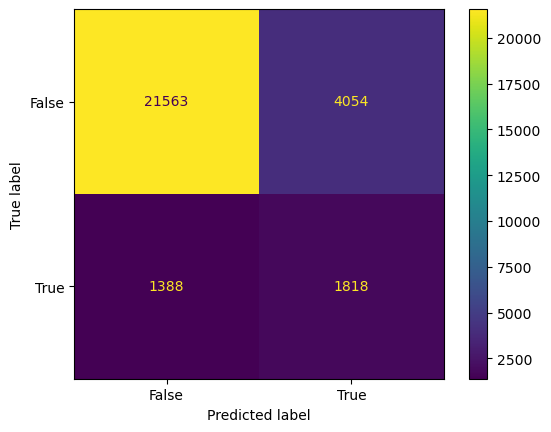

In [56]:
# plot confusion matrix for training set
confusion_matrix = metrics.confusion_matrix(y_train,predictions_train)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

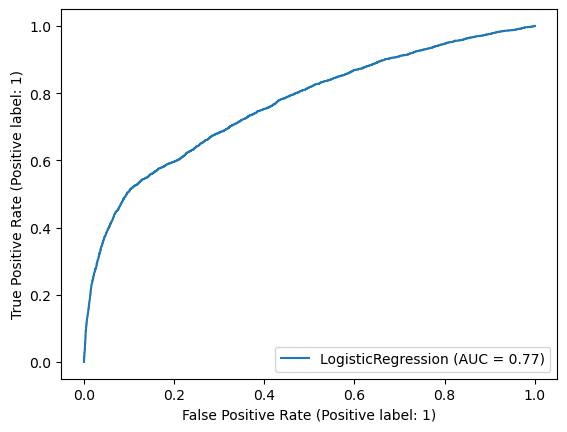

In [36]:
# use RocCurveDisplay to plot a ROC curve on training set
RocCurveDisplay.from_estimator(lr, X_train, y_train)
plt.show()

In [37]:
# score on test set

lr.score(X_test,y_test)

0.8077390107666154

In [38]:
# predict test set values
predictions_test = lr.predict(X_test)
print(classification_report(y_test,predictions_test))
# classification report on test set


              precision    recall  f1-score   support

           0       0.94      0.84      0.89     10920
           1       0.31      0.56      0.40      1433

    accuracy                           0.81     12353
   macro avg       0.62      0.70      0.64     12353
weighted avg       0.86      0.81      0.83     12353



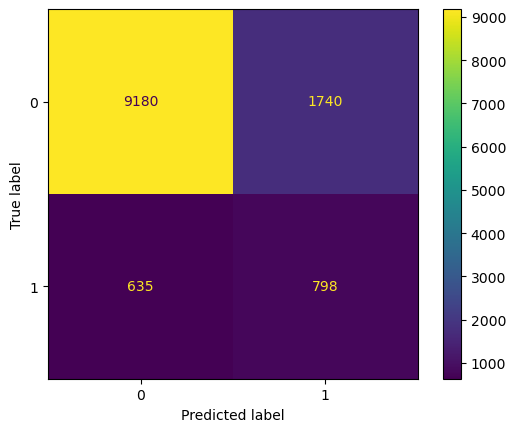

In [57]:
# plot confusion matrix for test set
confusion_matrix = metrics.confusion_matrix(y_test,predictions_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1])

cm_display.plot()
plt.show()

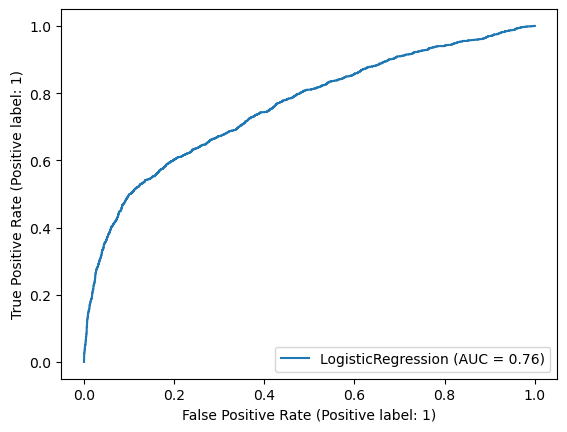

In [40]:
# use RocCurveDisplay to plot a ROC curve on test set
RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.show()
